In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
data = pd.read_csv("dataset_for_volume_classification_model_v1.csv", sep=",")

In [ ]:
data.head()

,width,height,surface,detected_object,object_condition,volume
0,0.405624,0.271085,0.109959,bottle,defective,0.5
1,0.395052,0.267947,0.105853,bottle,defective,0.5
2,0.440588,0.209557,0.092328,bottle,non_defective,0.5
3,0.450576,0.264297,0.119086,bottle,defective,0.5
4,0.419848,0.212147,0.089069,bottle,non_defective,0.5


In [ ]:
data.columns.tolist()

['width', 'height', 'surface', 'detected_object', 'object_condition', 'volume']

In [ ]:
encoded_data = pd.get_dummies(data, columns=["detected_object"], drop_first=True)

In [ ]:
encoded_data = pd.get_dummies(encoded_data, columns=["object_condition"], drop_first=True)

In [ ]:
encoded_data.head()

,width,height,surface,volume,detected_object_can,object_condition_non_defective
0,0.405624,0.271085,0.109959,0.5,0,0
1,0.395052,0.267947,0.105853,0.5,0,0
2,0.440588,0.209557,0.092328,0.5,0,1
3,0.450576,0.264297,0.119086,0.5,0,0
4,0.419848,0.212147,0.089069,0.5,0,1


In [ ]:
target = ['volume']
data[target] = data[target].astype('category')
X = encoded_data.drop(target, axis=1)
y = data[target]

In [ ]:
X

,width,height,surface,detected_object_can,object_condition_non_defective
0,0.405624,0.271085,0.109959,0,0
1,0.395052,0.267947,0.105853,0,0
2,0.440588,0.209557,0.092328,0,1
3,0.450576,0.264297,0.119086,0,0
4,0.419848,0.212147,0.089069,0,1
...,...,...,...,...,...
500,0.286300,0.257852,0.073823,1,0
501,0.281548,0.218445,0.061503,1,1
502,0.279923,0.250384,0.070088,1,0
503,0.282988,0.211404,0.059825,1,1


In [ ]:
y

,volume
0,0.50
1,0.50
2,0.50
3,0.50
4,0.50
...,...
500,0.24
501,0.24
502,0.24
503,0.24


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
y_train = pd.get_dummies(y_train).values

In [ ]:
y_test = pd.get_dummies(y_test).values

In [ ]:
y_val = pd.get_dummies(y_val).values

In [ ]:
X_train.shape

(363, 5)

In [ ]:
X_val.shape

(41, 5)

In [ ]:
X_test.shape

(101, 5)

In [ ]:
model = Sequential()
model.add(tf.keras.Input(shape=(len(X.columns),)))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(Dropout(0.1))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(Dropout(0.1))
model.add(tf.keras.layers.Dense(int(data[target].nunique())
, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_280 (Dense)           (None, 8)                 48        
                                                                 
 dense_281 (Dense)           (None, 16)                144       
                                                                 
 dropout_74 (Dropout)        (None, 16)                0         
                                                                 
 dense_282 (Dense)           (None, 32)                544       
                                                                 
 dropout_75 (Dropout)        (None, 32)                0         
                                                                 
 dense_283 (Dense)           (None, 5)                 165       
                                                                 
Total params: 901
Trainable params: 901
Non-trainable

In [ ]:
model.compile(optimizer='ADAM', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.99:
            print('\n Validation accuracy = \
            99% so, stopping further training.')
            self.model.stop_training = True


es = EarlyStopping(patience=5,
                   monitor='val_accuracy',
                   restore_best_weights=True,
                   verbose=1)

lr = ReduceLROnPlateau(monitor='val_loss',
                       patience=3,
                       factor=0.5,
                       verbose=1)

In [ ]:
# hyperparameters
EPOCHS = 150
BATCH_SIZE = 8

In [ ]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(X_val, y_val), callbacks = [es, lr, myCallback()])

Epoch 1/150
46/46 [==============================] - 1s 4ms/step - loss: 1.6237 - accuracy: 0.2727 - val_loss: 1.5406 - val_accuracy: 0.5122 - lr: 0.0010
Epoch 2/150
46/46 [==============================] - 0s 1ms/step - loss: 1.4455 - accuracy: 0.6033 - val_loss: 1.3941 - val_accuracy: 0.5610 - lr: 0.0010
Epoch 3/150
46/46 [==============================] - 0s 2ms/step - loss: 1.2836 - accuracy: 0.6446 - val_loss: 1.2575 - val_accuracy: 0.5610 - lr: 0.0010
Epoch 4/150
46/46 [==============================] - 0s 1ms/step - loss: 1.1156 - accuracy: 0.6584 - val_loss: 1.1607 - val_accuracy: 0.5610 - lr: 0.0010
Epoch 5/150
46/46 [==============================] - 0s 1ms/step - loss: 1.0115 - accuracy: 0.6474 - val_loss: 1.0884 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 6/150
46/46 [==============================] - 0s 1ms/step - loss: 0.9476 - accuracy: 0.7163 - val_loss: 1.0067 - val_accuracy: 0.7561 - lr: 0.0010
Epoch 7/150
46/46 [==============================] - 0s 1ms/step - loss: 0.8

In [ ]:
from matplotlib import pyplot as plt

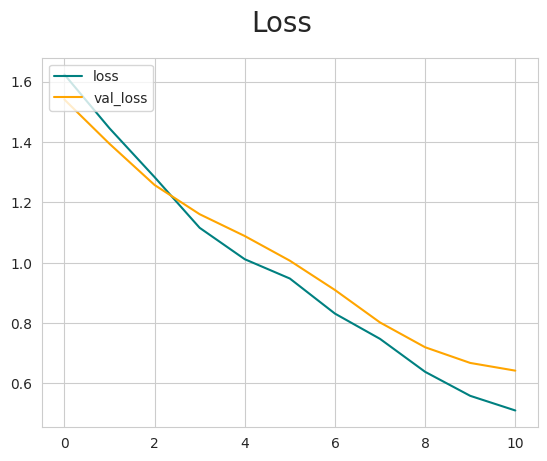

In [ ]:
fig = plt.figure()

plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

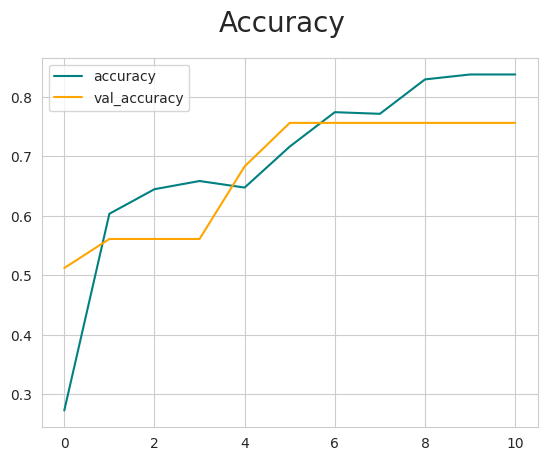

In [ ]:
fig = plt.figure()

plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
from sklearn import metrics

In [ ]:
y_pred = model.predict(X_test)

4/4 [==============================] - 0s 938us/step


In [ ]:
y_pred

array([[4.47059982e-02, 5.21694779e-01, 8.51166025e-02, 2.72318006e-01,
        7.61646107e-02],
       [2.39600390e-02, 3.26022595e-01, 9.37200189e-02, 4.48282897e-01,
        1.08014539e-01],
       [9.72823322e-01, 1.86159387e-02, 2.80246441e-03, 5.59707684e-03,
        1.61164833e-04],
       [9.14194658e-02, 4.64528382e-01, 1.14569470e-01, 2.38873824e-01,
        9.06088054e-02],
       [3.50657403e-02, 2.59948373e-01, 1.13921538e-01, 4.64063853e-01,
        1.27000481e-01],
       [4.73365448e-02, 5.39187968e-01, 8.36099461e-02, 2.57070720e-01,
        7.27947801e-02],
       [2.34444421e-02, 3.27696532e-01, 9.30247456e-02, 4.49022382e-01,
        1.06811948e-01],
       [8.06317702e-02, 4.40390140e-01, 1.16692513e-01, 2.63873786e-01,
        9.84117314e-02],
       [4.36374918e-02, 4.98509824e-01, 8.77405927e-02, 2.89129704e-01,
        8.09822902e-02],
       [7.69624114e-02, 4.12661403e-01, 1.20130062e-01, 2.84572870e-01,
        1.05673276e-01],
       [3.62347662e-02, 2.6438

In [ ]:
max_indices = np.argmax(y_pred, axis=1)

In [ ]:
y_pred = np.eye(y_pred.shape[1])[max_indices]

In [ ]:
y_pred = y_pred.astype(int)

In [ ]:
y_pred

array([[0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [1, 0, 0, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0,

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        16
           1       0.93      1.00      0.97        43
           2       0.00      0.00      0.00         8
           3       0.65      1.00      0.79        26
           4       0.00      0.00      0.00         8

   micro avg       0.83      0.83      0.83       101
   macro avg       0.52      0.59      0.54       101
weighted avg       0.72      0.83      0.77       101
 samples avg       0.83      0.83      0.83       101



/home/wissem/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


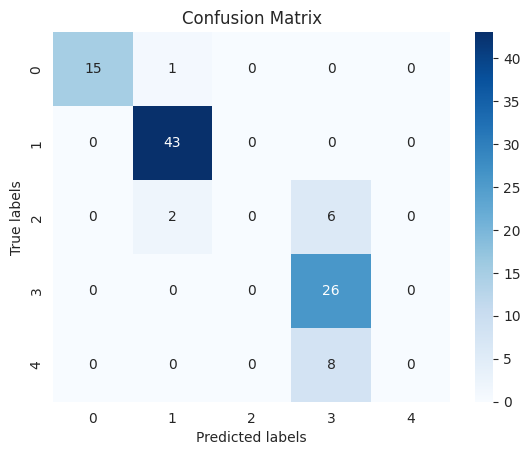

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assume `y_true` and `y_pred` are your true and predicted labels, respectively
labels = ['0', '1', '2', '3', '4']  # Replace with your own label names
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

# Create heatmap visualization of confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()